In [1]:
sessionInfo()

R version 4.0.1 (2020-06-06)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.5

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] compiler_4.0.1  IRdisplay_0.7.0 pbdZMQ_0.3-3    tools_4.0.1    
 [5] htmltools_0.5.0 pillar_1.4.4    base64enc_0.1-3 crayon_1.3.4   
 [9] uuid_0.1-4      IRkernel_1.1    jsonlite_1.6.1  digest_0.6.25  
[13] repr_1.1.0      rlang_0.4.6     evaluate_0.14  

In [4]:
library(tableone)
library(MatchIt)
library(ggplot2)

In [5]:
#load dataset
load(url("http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/rhc.sav"))

In [6]:
# create new dataset: only variables that will be used, convert character to numeric

ARF <- as.numeric(rhc$cat1 == 'ARF')
CHF<- as.numeric(rhc$cat1=='CHF')
Cirr<- as.numeric(rhc$cat1 == 'Cirrhosis')
colcan <- as.numeric(rhc$cat1 == 'Colon Cancer')
Coma<- as.numeric(rhc$cat1 == 'Coma')
COPD <- as.numeric(rhc$cat1 == 'COPD')
lungcan <- as.numeric(rhc$cat1 == 'Lung Cancer')
MOSF <- as.numeric(rhc$cat1 == 'MOSF w/Malignancy')
sepsis<- as.numeric(rhc$cat1 == 'MOSF w/Sepsis')
female <- as.numeric(rhc$sex == 'Female')
died <- as.numeric(rhc$death == 'Yes')
age <- rhc$age
treatment <- as.numeric(rhc$swang1 == 'RHC')
meanbp1 <- rhc$meanbp1
aps <- rhc$aps1


mydata<- cbind(ARF, CHF, Cirr, colcan, Coma, lungcan, MOSF, sepsis, age, female, meanbp1, aps, treatment, died)
mydata <- data.frame(mydata)



In [7]:
#compute propensity score using logistic models
psmodel <- glm(treatment~ ARF+ CHF+ Cirr+ colcan + Coma+ lungcan+ MOSF + sepsis + age + female + meanbp1 + aps,
               family = binomial(), data = mydata)
#show coefficients
summary(psmodel)


Call:
glm(formula = treatment ~ ARF + CHF + Cirr + colcan + Coma + 
    lungcan + MOSF + sepsis + age + female + meanbp1 + aps, family = binomial(), 
    data = mydata)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0498  -0.9602  -0.6190   1.1289   2.3878  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.9460154  0.2321291  -8.383  < 2e-16 ***
ARF          1.2252930  0.1495511   8.193 2.54e-16 ***
CHF          1.8905642  0.1735687  10.892  < 2e-16 ***
Cirr         0.4334062  0.2203366   1.967  0.04918 *  
colcan       0.0481566  1.1242894   0.043  0.96583    
Coma         0.6842545  0.1878333   3.643  0.00027 ***
lungcan      0.1984600  0.5055005   0.393  0.69461    
MOSF         1.0177797  0.1807159   5.632 1.78e-08 ***
sepsis       1.8402456  0.1561589  11.784  < 2e-16 ***
age         -0.0030469  0.0017462  -1.745  0.08101 .  
female      -0.1390768  0.0590139  -2.357  0.01844 *  
meanbp1     -0.0075166  0.0008707  -8.633

In [8]:
# that's propensity score
pscore <- psmodel$fitted.values

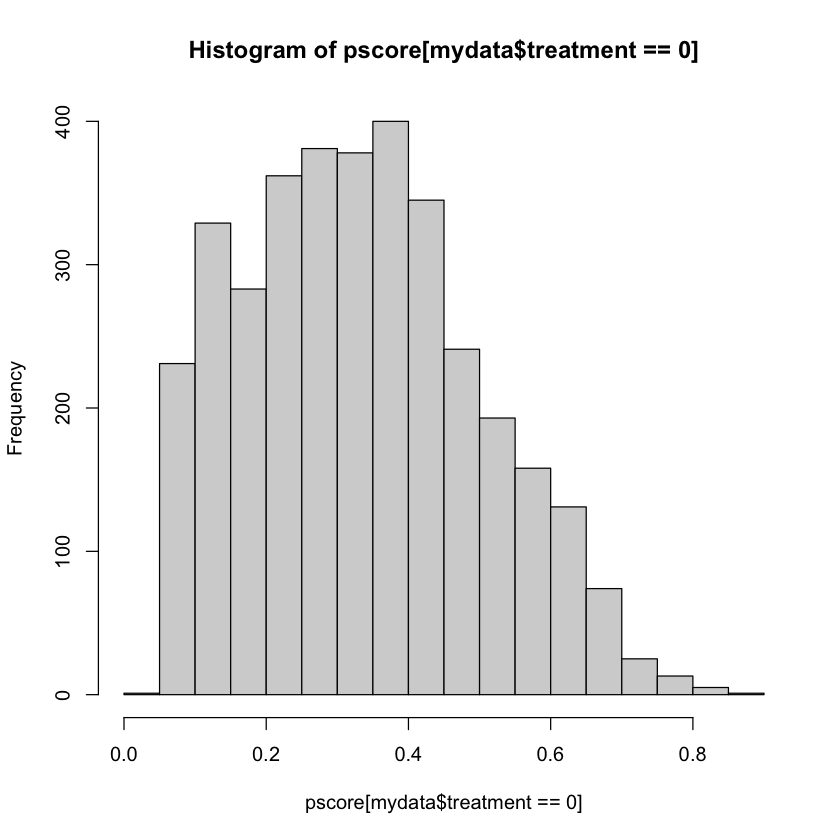

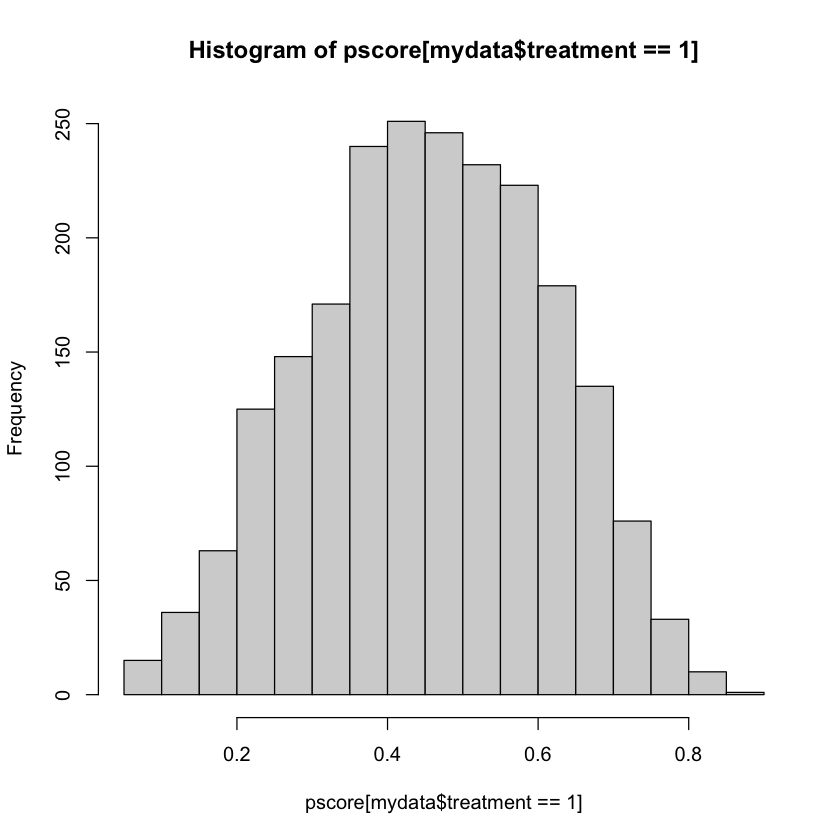

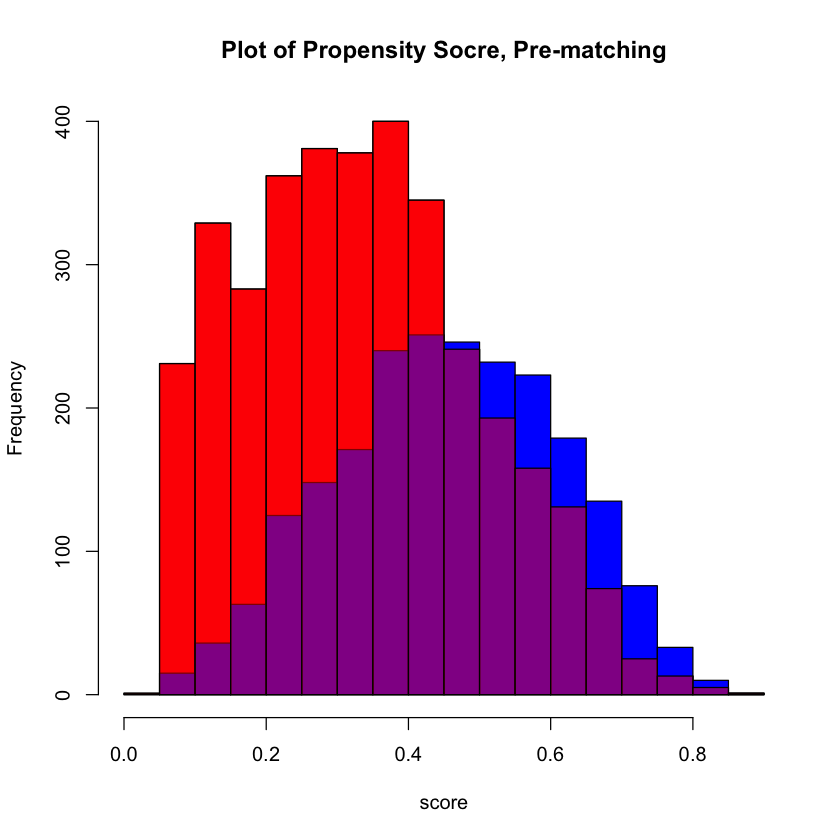

In [11]:
#now look at the plot of propensity score, prematching
hist_control<- hist(pscore[mydata$treatment==0])
hist_treat<- hist(pscore[mydata$treatment==1])
plot(hist_control, col= 'red',, main = 'Plot of Propensity Socre, Pre-matching', xlab= 'score')
plot(hist_treat, add= TRUE, col='blue')
plot(hist_control, col=rgb(1,0,0,0.5), add=T)

In [12]:

#use matchit for propensity score, nearest neigbor matching
m.out <- matchit(treatment~ ARF+CHF+Cirr+ colcan + Coma + lungcan + MOSF + sepsis +
                   age+ female + meanbp1+ aps, data= mydata, method = 'nearest')

summary(m.out)




Call:
matchit(formula = treatment ~ ARF + CHF + Cirr + colcan + Coma + 
    lungcan + MOSF + sepsis + age + female + meanbp1 + aps, data = mydata, 
    method = "nearest")

Summary of balance for all data:
         Means Treated Means Control SD Control Mean Diff eQQ Med eQQ Mean
distance        0.4568        0.3341     0.1628    0.1227  0.1327   0.1228
ARF             0.4162        0.4452     0.4971   -0.0290  0.0000   0.0288
CHF             0.0957        0.0696     0.2544    0.0261  0.0000   0.0261
Cirr            0.0224        0.0493     0.2165   -0.0268  0.0000   0.0266
colcan          0.0005        0.0017     0.0411   -0.0012  0.0000   0.0014
Coma            0.0435        0.0960     0.2947   -0.0525  0.0000   0.0527
lungcan         0.0023        0.0096     0.0974   -0.0073  0.0000   0.0073
MOSF            0.0723        0.0679     0.2516    0.0045  0.0000   0.0046
sepsis          0.3205        0.1484     0.3556    0.1721  0.0000   0.1722
age            60.7498       61.7609    17.

[1] "To identify the units, use first mouse button; to stop, use second."


integer(0)

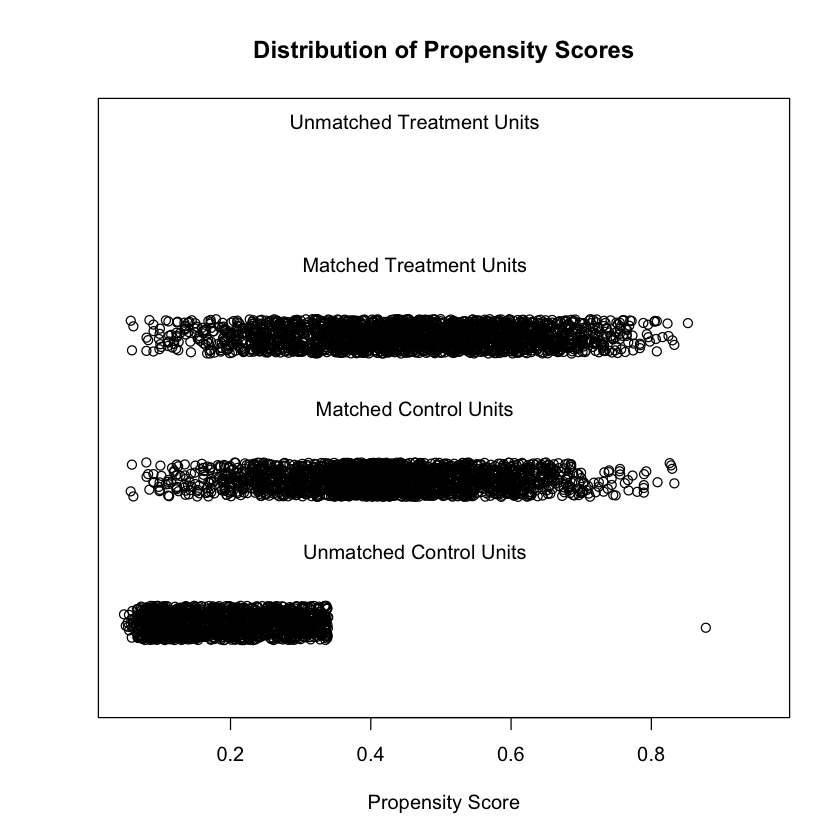

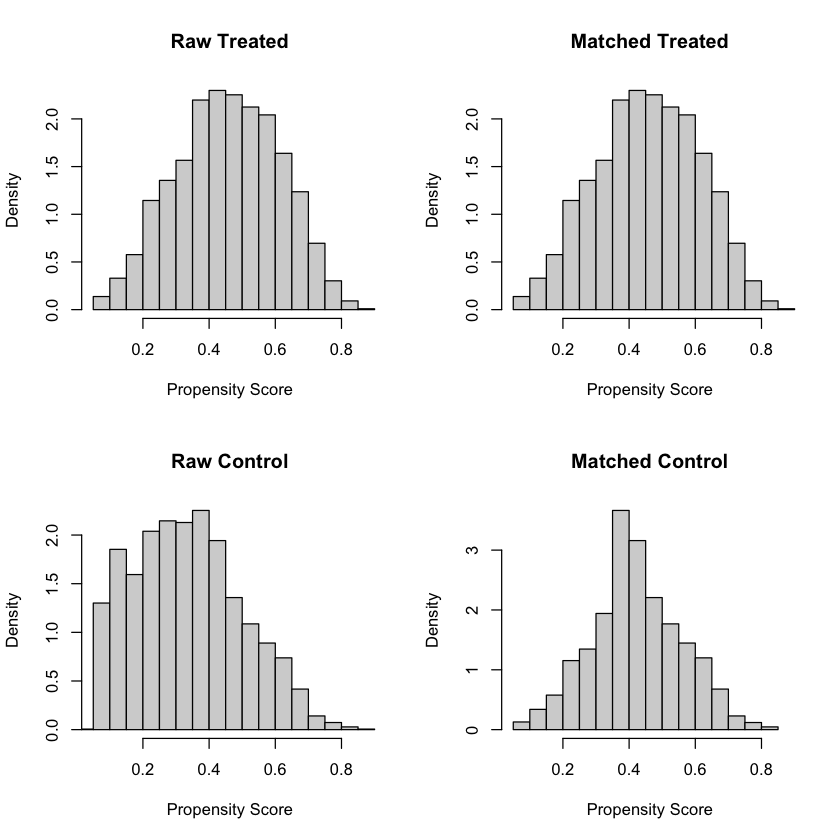

In [13]:
#propensity score plots
plot(m.out, type =  'jitter') #make sure the distribution looks similar for the matched units
plot(m.out, type = 'hist')

In [14]:
#use differnt package

#No caliper used here:
library(Matching)
psmatch<- Match(Tr= mydata$treatment, M=1, X= log(pscore), replace= FALSE)
matched <- mydata[unlist(psmatch[c('index.treated', 'index.control')]),]
xvars <- c('ARF', 'CHF', 'Cirr', 'colcan', 'Coma', 'lungcan', 'MOSF', 'sepsis',
           'age', 'female', 'meanbp1', 'aps')
matchedtab1<- CreateTableOne(vars= xvars, strata = 'treatment', data = matched, test= FALSE)
print(matchedtab1,smd= TRUE)

Loading required package: MASS

## 
##  Matching (Version 4.9-7, Build Date: 2020-02-05)
##  See http://sekhon.berkeley.edu/matching for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##




                     Stratified by treatment
                      0             1             SMD   
  n                    2184          2184               
  ARF (mean (SD))      0.49 (0.50)   0.42 (0.49)   0.142
  CHF (mean (SD))      0.10 (0.30)   0.10 (0.29)   0.018
  Cirr (mean (SD))     0.03 (0.16)   0.02 (0.15)   0.035
  colcan (mean (SD))   0.00 (0.00)   0.00 (0.02)   0.030
  Coma (mean (SD))     0.04 (0.20)   0.04 (0.20)   0.005
  lungcan (mean (SD))  0.00 (0.06)   0.00 (0.05)   0.017
  MOSF (mean (SD))     0.08 (0.27)   0.07 (0.26)   0.036
  sepsis (mean (SD))   0.24 (0.43)   0.32 (0.47)   0.184
  age (mean (SD))     61.26 (17.99) 60.75 (15.63)  0.030
  female (mean (SD))   0.44 (0.50)   0.41 (0.49)   0.045
  meanbp1 (mean (SD)) 72.19 (34.70) 68.20 (34.24)  0.116
  aps (mean (SD))     57.22 (18.55) 60.74 (20.27)  0.181


In [15]:
#use caliper
psmatch<- Match(Tr= mydata$treatment, M=1, X= log(pscore), replace= FALSE, caliper = 0.2)
matched <- mydata[unlist(psmatch[c('index.treated', 'index.control')]),]
xvars <- c('ARF', 'CHF', 'Cirr', 'colcan', 'Coma', 'lungcan', 'MOSF', 'sepsis',
           'age', 'female', 'meanbp1', 'aps')

matchedtab1<- CreateTableOne(vars= xvars, strata = 'treatment', data = matched, test= FALSE)
print(matchedtab1,smd= TRUE)



                     Stratified by treatment
                      0             1             SMD   
  n                    1908          1908               
  ARF (mean (SD))      0.48 (0.50)   0.45 (0.50)   0.050
  CHF (mean (SD))      0.10 (0.30)   0.10 (0.29)   0.002
  Cirr (mean (SD))     0.03 (0.16)   0.03 (0.16)  <0.001
  colcan (mean (SD))   0.00 (0.00)   0.00 (0.02)   0.032
  Coma (mean (SD))     0.04 (0.19)   0.05 (0.21)   0.041
  lungcan (mean (SD))  0.00 (0.06)   0.00 (0.05)   0.019
  MOSF (mean (SD))     0.08 (0.28)   0.08 (0.27)   0.023
  sepsis (mean (SD))   0.26 (0.44)   0.27 (0.44)   0.032
  age (mean (SD))     61.08 (17.81) 61.04 (15.47)  0.003
  female (mean (SD))   0.42 (0.49)   0.43 (0.49)   0.010
  meanbp1 (mean (SD)) 72.56 (35.01) 71.40 (34.94)  0.033
  aps (mean (SD))     57.88 (19.06) 58.21 (19.39)  0.017


In [ ]:
### 